In [1]:
import sys
import yaml

import numpy as np
import pandas as pd
import anndata
import h5py
import os
import scipy
import tqdm

import torch
from plotnine import *
%matplotlib inline

pd.options.mode.chained_assignment = None 

/home/karollua/miniforge3/envs/phylop_model/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/karollua/miniforge3/envs/phylop_model/lib/python3.12/site-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

# Paths

In [2]:
ckpts={
'kugrjb50': '/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/kugrjb50/checkpoints/epoch=3-step=2920.ckpt',
'i68hdsdk': '/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/i68hdsdk/checkpoints/epoch=2-step=2190.ckpt',
'0as9e8of': '/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/0as9e8of/checkpoints/epoch=7-step=5840.ckpt',
'i9zsp4nm': '/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/i9zsp4nm/checkpoints/epoch=8-step=6570.ckpt',
}

matrix_file = "/gstore/data/resbioai/grelu/decima/20240823/data.h5ad"
h5_file = "/gstore/data/resbioai/grelu/decima/20240823/data.h5"
meme_file_modisco = "/gstore/data/resbioai/karollua/Decima/scborzoi/decima/data/jaspar/H12CORE_meme_format.meme"
motif_json = '/gstore/data/resbioai/karollua/Decima/scborzoi/decima/data/jaspar/H12CORE_annotation.jsonl'
motifcluster_path = "/gstore/data/resbioai/karollua/Decima/scborzoi/decima/data/jaspar/cluster/cluster_key.txt"

# where to save results
save_dir = "/gstore/data/resbioai/karollua/Decima/scborzoi/decima/"
ensembl_out_dir = "/gstore/data/resbioai/karollua/Decima/scborzoi/decima/results/ensemble"

## Load data

In [3]:
ad = anndata.read_h5ad(anndata_file)

In [ ]:
def rename_fn(disease,cell_type,tissue,study):
    return f"{disease.replace(' ','_').replace("'","").replace("'","").replace("(","").replace(")","")}__{cell_type.replace(' ','_').replace(',','_')}__{tissue.replace(' ','_').replace('-','_')}__{study.replace('-','_')}"

## List all case studies

In [22]:
# cutoff set to ~300 genes
case_studies = [
    {
        "study" : "17481d16-ee44-49e5-bcf0-28c0780d8c4a",	
        "disease" : "Crohn\'s disease",	
        "tissue" : "ileum",	
        "cell_type" : "fibroblast",
        'pred_cut': 1.5,
    },
    {
        "study" : "DS000011665",	
        "disease" : "Crohn\'s disease",	
        "tissue" : "ileum",	
        "cell_type" : "fibroblast",
        'pred_cut': 0.405,
    },
    {
        "study" : "DS000010618",	
        "disease" : "ulcerative colitis",	
        "tissue" : "ascending colon",	
        "cell_type" : "fibroblast",
        'pred_cut': 0.405,
    },
    {
        "study" : "GSE132771",
        "disease" : "idiopathic pulmonary fibrosis",
        "tissue" :  "lung",
        "cell_type" : "fibroblast",
        'pred_cut': 0.625,
    },
    {
        "study" : "GSE132771",
        "disease" : "scleroderma",
        "tissue" :  "lung",
        "cell_type" : "fibroblast",
        'pred_cut': 0.73,
    },
    {
        "study" : "GSE128169",
        "disease" : "scleroderma",
        "tissue" :  "lung",
        "cell_type" : "fibroblast",
        'pred_cut': 0.63,
    },
    {
        "study" : "DS000010618",
        "disease" : "ulcerative colitis",
        "tissue" :  "colon",
        "cell_type" : "enterocyte",
        'pred_cut': 1.05,
    },
    {
        "study" : "17481d16-ee44-49e5-bcf0-28c0780d8c4a",
        "disease" : "Crohn\'s disease",
        "tissue" :  "ileum",
        "cell_type" : "enterocyte",
        'pred_cut': 1.25,
    },
    {
        "study" : "DS000011735",
        "disease" : "idiopathic pulmonary fibrosis",
        "tissue" :  "lung",
        "cell_type" : "type II pneumocyte",
        'pred_cut': 0.7,
    },
    {
        "study" : "GSE128033",
        "disease" : "idiopathic pulmonary fibrosis",
        "tissue" :  "lung",
        "cell_type" : "type II pneumocyte",
        'pred_cut': 0.56,
    },
    {
        "study" : "GSE128169",
        "disease" : "scleroderma",
        "tissue" :  "lung",
        "cell_type" : "type II pneumocyte",
        'pred_cut': 0.655,
    },
    {
        "study" : "SCP2613",
        "disease" : "atopic dermatitis (lesional)",
        "tissue" :  "skin",
        "cell_type" : "Keratinocyte 3",
        'pred_cut': 0.57,
    },
    {
        "study" : "E-MTAB-8142",
        "disease" : "atopic dermatitis (lesional)",
        "tissue" :  "skin",
        "cell_type" : "Keratinocyte 3",
        'pred_cut': 0.525,
    },
    {
        "study" : "e75342a8-0f3b-4ec5-8ee1-245a23e0f7cb",
        "disease" : "cardiomyopathy",
        "tissue" :  "heart left ventricle",
        "cell_type" : "fibroblast",
        'pred_cut': 0.335,
    },
    {
        "study" : "8191c283-0816-424b-9b61-c3e1d6258a77",
        "disease" : "myocardial infarction",
        "tissue" :  "heart left ventricle",
        "cell_type" : "fibroblast",
        'pred_cut': 0.48,
    },
    {
        "study" : "GSE158127",
        "disease" : "COVID-19",
        "tissue" :  "lung parenchyma",
        "cell_type" : "fibroblast",
        'pred_cut': 0.39,
    },
    {
        "study" : "bcb61471-2a44-4d00-a0af-ff085512674c",
        "disease" : "chronic kidney disease",
        "tissue" :  "renal medulla",
        "cell_type" : "fibroblast",
        'pred_cut': 0.475,
    },
    {
        "study" : "GSE163122",
        "disease" : "Alzheimer\'s disease",
        "tissue" :  "Cerebral cortex_Occipital Cortex",
        "cell_type" : "fibroblast",
        'pred_cut': 0.45,
    },
        {
        "cell_type":"type II pneumocyte",
        "tissue":"lung",
        "disease":"chronic obstructive pulmonary disease",
        "study":"DS000011735",
        'pred_cut':0.82,
    },
    {
        "cell_type":"CD8-positive, alpha-beta T cell",
        "tissue":"blood",
        "disease":"systemic lupus erythematosus",
        "study":"GSE156989",
        'pred_cut':0.82,
    },
    {
        "cell_type":"CD4-positive, alpha-beta T cell",
        "tissue":"blood",
        "disease":"COVID-19",
        "study":"ddfad306-714d-4cc0-9985-d9072820c530",
        'pred_cut':0.78,
    },
    {
        "cell_type":"memory B cell",
        "tissue":"blood",
        "disease":"systemic lupus erythematosus",
        "study":"GSE156989",
        'pred_cut':0.625,
    },
    {
        "cell_type":"Fibroblast APOC1+",
        "tissue":"skin",
        "disease":"atopic dermatitis (non-lesional)",
        "study":"SCP2613",
        'pred_cut':0.43,
    },
    {
        "cell_type":"Microglia",
        "tissue":"Grey matter_Motor cortex",
        "disease":"Amyotrophic lateral sclerosis",
        "study":"GSE174332",
        'pred_cut':0.58,
    },
    {
        "cell_type":"goblet cell",
        "tissue":"ileum",
        "disease":"Crohn's disease",
        "study":"17481d16-ee44-49e5-bcf0-28c0780d8c4a",
        'pred_cut':1.18,
    },
]

## Compute attributions for each case study and model replicate

In [150]:
for case_study in case_studies:

    study = case_study['study']
    disease = case_study['disease']
    tissue = case_study['tissue']
    cell_type = case_study['cell_type']
    ct = cell_type
    pred_cut = case_study['pred_cut']

    on_tasks = ad[ad.obs.cell_type==ct & ad.obs.tissue==tissue & ad.obs.disease == disease & ad.obs.study == study].index.tolist()
    off_tasks = ad[ad.obs.cell_type==ct & ad.obs.tissue==tissue & ad.obs.disease== 'healthy' & ad.obs.study == study.index.tolist()
    
    diff_df = pd.DataFrame({'gene':list(ad.var.index), 'pred_diff': ad[on_tasks].layers['preds'].mean(0) - ad[off_tasks].layers['preds'].mean(0)})
    diff_df = diff_df[diff_df.pred_diff > pred_cut]

    task_df = pd.DataFrame([{"task_type":"on",'task':on_tasks[0]}, {"task_type":"off",'task':off_tasks[0]}])
    
    devices = [4,5,6,7]
    i = 0
    for run_id, ckpt_file in ckpts.items():
        device = devices[i]        
        results_path_model = os.path.join(save_dir, "results", run_id)
        name = rename_fn(disease,cell_type,tissue,study)
        
        out_dir = os.path.join(results_path_model, name)
        gene_df_file = os.path.join(out_dir,'gene_df.csv')
        targets_file = os.path.join(out_dir,'targets.csv')
        
        # write gene and task df
        logfc_df.to_csv(gene_df_file, index=None)
        task_df.to_csv(targets_file, index=None)
        
        # make and execute command
        cmd = f"python Interpret.py -device {device} -ckpt_file {ckpt_file} -h5_file {h5_file} -gene_df_file {gene_df_file} \
            -targets_file {targets_file} -out_dir {out_dir}"
        cmd = " ".join(cmd.split())
        print(cmd)
        i += 1

24
4 goblet cell Crohn's disease /gstore/data/resbioai/grelu/decima/20240823/lightning_logs/kugrjb50/checkpoints/epoch=3-step=2920.ckpt /gstore/data/resbioai/karollua/Decima/scborzoi/decima/results/kugrjb50
python Interpret.py -device 4 -ckpt_file /gstore/data/resbioai/grelu/decima/20240823/lightning_logs/kugrjb50/checkpoints/epoch=3-step=2920.ckpt -h5_file /gstore/data/resbioai/grelu/decima/20240823/data.h5 -gene_df_file /gstore/data/resbioai/karollua/Decima/scborzoi/decima/results/kugrjb50/Crohns_disease__goblet_cell__ileum__17481d16_ee44_49e5_bcf0_28c0780d8c4a/gene_df.csv -targets_file /gstore/data/resbioai/karollua/Decima/scborzoi/decima/results/kugrjb50/Crohns_disease__goblet_cell__ileum__17481d16_ee44_49e5_bcf0_28c0780d8c4a/targets.csv -out_dir /gstore/data/resbioai/karollua/Decima/scborzoi/decima/results/kugrjb50/Crohns_disease__goblet_cell__ileum__17481d16_ee44_49e5_bcf0_28c0780d8c4a > ../logs/interpretDisease_kugrjb50_Crohns_disease__goblet_cell__ileum__17481d16_ee44_49e5_bcf0

## Average attributions and run modisco for each case study

In [151]:
for case_study in tqdm.tqdm(case_studies):
    study = case_study['study']
    disease = case_study['disease']
    tissue = case_study['tissue']
    cell_type = case_study['cell_type']
    ct = cell_type
    
    name = rename_fn(disease,cell_type,tissue,study)
    results_path_ensemble = os.path.join(ensembl_out_dir, name)

    attrs = []
    for run_id, ckpt_file in ckpts.items():
        results_path_model = os.path.join(save_dir, "results", run_id)
        attr = np.load(os.path.join(results_path_model,name,"attributions.npy"))
        attrs.append(attr)

    # get path to attributions and one hot sequences
    seq_file = os.path.join(results_path_ensemble,'sequences.npy')
    attr_file = os.path.join(results_path_ensemble,'attributions.npy')
        
    # average the attributions
    attrs = np.stack(attrs).mean(0)
    np.save(attr_file, attrs)
    
    # save one sequence tensor
    seq = np.load(os.path.join(results_path_model, name, "sequences.npy"))
    np.save(seq_file, seq)

    # make command
    cmd = f"python InterpretModisco.py -seq_file {seq_file} -attr_file {attr_file} -meme_file {meme_file_modisco} -out_dir {results_path_ensemble} -seqlets 50000"
    print(cmd)

  0%|          | 0/25 [00:00<?, ?it/s]

(304, 4, 524288)


 76%|███████▌  | 19/25 [00:23<00:07,  1.24s/it]

(307, 4, 524288)


 80%|████████  | 20/25 [00:42<00:12,  2.49s/it]

(303, 4, 524288)


 84%|████████▍ | 21/25 [01:01<00:15,  3.95s/it]

(311, 4, 524288)


 88%|████████▊ | 22/25 [01:26<00:19,  6.41s/it]

(306, 4, 524288)


 92%|█████████▏| 23/25 [01:43<00:15,  7.82s/it]

(306, 4, 524288)


 96%|█████████▌| 24/25 [02:11<00:11, 11.27s/it]

(301, 4, 524288)


100%|██████████| 25/25 [02:35<00:00,  6.22s/it]


## Match modisco results to motif cluster

In [27]:
rows = []

for cs in case_studies:
    print(cs)
    study = cs['study']
    disease = cs['disease']
    tissue = cs['tissue']
    cell_type = cs['cell_type']
    ct = cell_type
    
    attrs = []

    modisco_name = rename_fn(disease,cell_type,tissue,study)
    modisco_dir = os.path.join(ensembl_out_dir,modisco_name)
    modisco_h5 = os.path.join(modisco_dir,'modisco_full','modisco_report.h5')
    
    f = h5py.File(modisco_h5, 'r')
    for i in range(len(f['pos_patterns'])):
        num_seqlets = f['pos_patterns'][f'pattern_{i}']['seqlets']['n_seqlets'][0]
        row = {'cell_type':cell_type, 'disease':disease, 'tissue':tissue, 'study':study, 'pattern':i, 'count':num_seqlets}

        tomtom = pd.read_csv(os.path.join(modisco_dir,'modisco_full', 'tomtom',f"pos_patterns.pattern_{i}.tomtom.tsv"),sep="\t").dropna()
        tomtom = tomtom[tomtom['q-value'] < 0.05]
        if len(tomtom) > 0:
            target = tomtom.sort_values('q-value')['Target_ID'].iloc[0]
            top_target = tf_to_family_dict[target]['tf']
            top_cluster = tf_to_motifcluster_dict[target]
            if top_target is not None:
                row['target'] = top_target
                row['cluster'] = top_cluster
                rows.append(row)

ct_motif_df = pd.DataFrame(rows)

## TWIST1

In [ ]:
seqlet_counts = ct_motif_df.groupby(['cell_type','disease','tissue','study'])['count'].sum().reset_index().rename(columns={'count':'total'})
twist_df = ct_motif_df.query('top_target == "TWST1"')[['cell_type','disease','tissue','study','count']].merge(
    seqlet_counts, how='right', on=['cell_type','disease','tissue','study']).fillna(0)

In [29]:
subdf_list = []
for cs in case_studies:
    on_tasks = ad[ad.obs.cell_type==ct & ad.obs.tissue==tissue & ad.obs.disease == disease & ad.obs.study == study].index.tolist()
    off_tasks = ad[ad.obs.cell_type==ct & ad.obs.tissue==tissue & ad.obs.disease== 'healthy' & ad.obs.study == study.index.tolist()
    sub_df = pd.DataFrame({'gene':list(ad.var.index), 'true_diff': ad[on_tasks].X.mean(0) - ad[off_tasks].X.mean(0)})
    subdf_list.append(sub_df)

cs_diff_df = pd.concat(subdf_list).reset_index()    

In [30]:
twist_df = twist_df.merge(cs_diff_df.query('gene == "TWIST1"')[['cell_type','disease','tissue','study','true_diff']], 
                          on=['cell_type','disease','tissue','study'])
twist_df['motif_detected'] = twist_df['count'] > 0

PearsonRResult(statistic=0.7639655500989944, pvalue=8.819952795161782e-06)


MannwhitneyuResult(statistic=111.0, pvalue=0.003972020440337957)


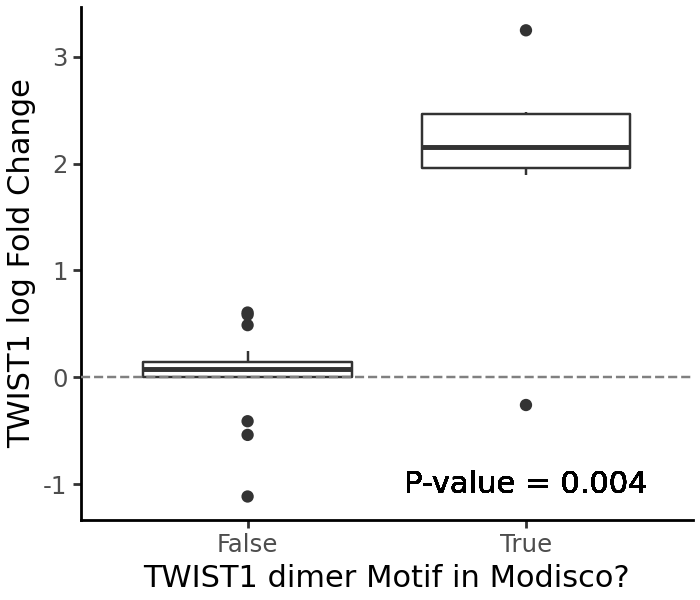

In [32]:
pval = scipy.stats.mannwhitneyu(twist_df.query('motif_detected')['true_diff'], twist_df.query('not motif_detected')['true_diff'])
print(pval)
(
    ggplot(twist_df, aes(x='motif_detected', y = 'true_diff')) +\
    geom_boxplot() + theme_classic() + theme(figure_size=(3.5, 3.0)) 
    + xlab("TWIST1 dimer Motif in Modisco?") + ylab("TWIST1 log Fold Change")
    + geom_vline(xintercept=0, color='grey', linetype='dashed')
    + geom_hline(yintercept=0, color='grey', linetype='dashed')
    + geom_text(x=2, y=-1, label=f"P-value = {np.round(pval[1], 4)}") 
    + theme(plot_title = element_text(size=12))
)